# [Regression Error Characteristic Curves](https://jinbo-bi.uconn.edu/rec/)

Receiver Operating Characteristic (ROC) curves provide a powerful tool for visualizing and comparing classification results. **Regression Error Characteristic** (REC) curves generalize ROC curves to regression.

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from scipy.integrate import simps

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

In [2]:
SEED = 42

## Simulate Data

In [3]:
np.random.seed(SEED)

n_size = 125
demo_x = np.random.normal(size=n_size)
beta_0 = 10
beta_1 = 4
beta_2 = 1.25

pure_fnc = np.poly1d(np.array([beta_2, beta_1, beta_0]))
# demo_y_pure = beta_0 + beta_1 * demo_x + beta_2 * demo_x**2
demo_y_pure = pure_fnc(demo_x)
demo_epsilon = np.random.normal(0, 1, size=n_size)
demo_y = demo_y_pure + demo_epsilon

### Plot

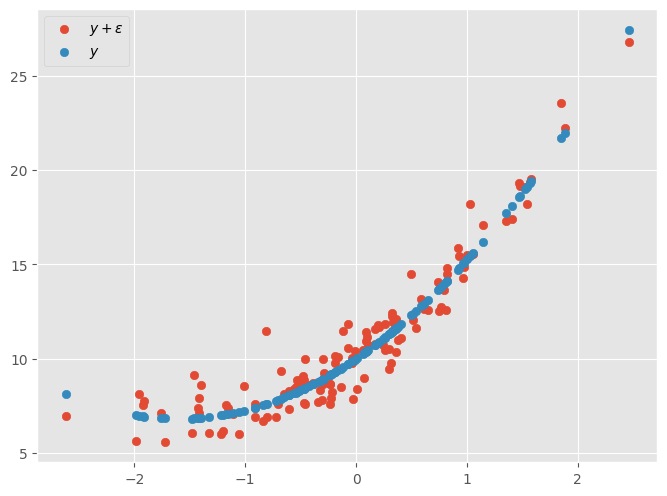

In [4]:
# plot
fig = plt.figure(figsize=(8,6), dpi=100)

plt.scatter(demo_x, demo_y, label='$y + \epsilon$')
plt.scatter(demo_x, demo_y_pure, label='$y$')
plt.legend()
plt.show()

## Train-Test Split

In [5]:
split_index = round(n_size * 0.8)

In [6]:
demo_x_train, demo_x_test = demo_x[:split_index], demo_x[split_index:]
demo_y_train, demo_y_test = demo_y[:split_index], demo_y[split_index:]

### Plot

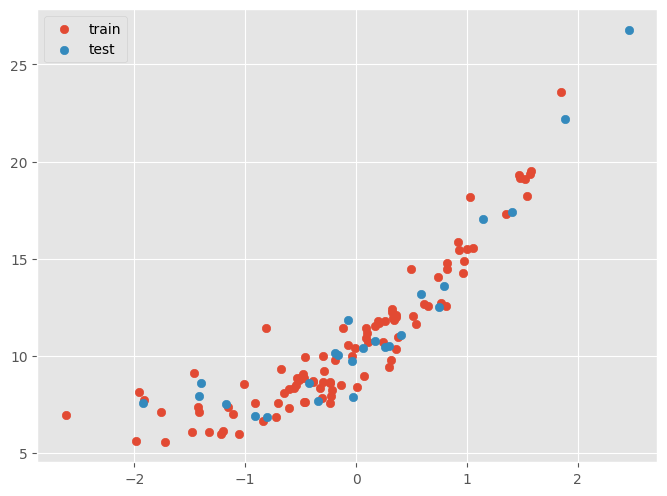

In [7]:
# plot
fig = plt.figure(figsize=(8,6), dpi=100)

plt.scatter(demo_x_train, demo_y_train, label='train')
plt.scatter(demo_x_test, demo_y_test, label='test')
plt.legend()
plt.show()

## Fit Models

In [8]:
lin_reg_model = np.polyfit(demo_x_train, demo_y_train, 1)
sqr_reg_model = np.polyfit(demo_x_train, demo_y_train, 2)

In [9]:
lin_reg_model, sqr_reg_model

(array([ 3.62930922, 11.07968394]),
 array([ 1.25263784,  4.08785958, 10.09098763]))

In [10]:
lin_fnc = np.poly1d(lin_reg_model)
sqr_fnc = np.poly1d(sqr_reg_model)

## Predict

In [11]:
lin_y_hat =lin_fnc(demo_x_test)
sqr_y_hat = sqr_fnc(demo_x_test)

## Plot Results

In [12]:
x_dots = np.linspace(np.floor(np.min(demo_x)), np.ceil(np.max(demo_x)), 50)

In [13]:
lin_y_dots = lin_fnc(x_dots)
sqr_y_dots = sqr_fnc(x_dots)

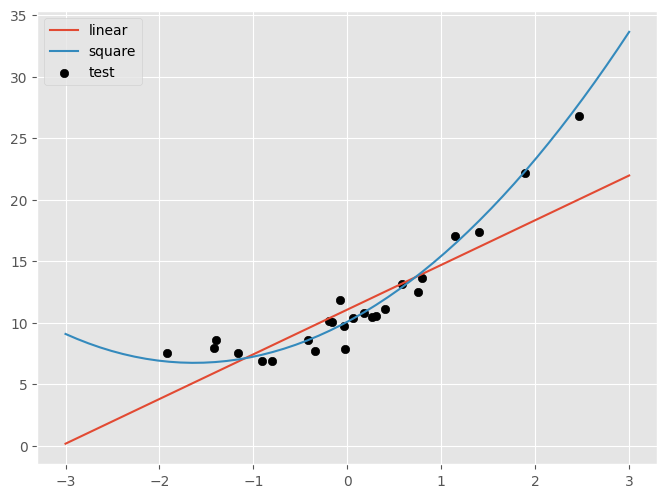

In [14]:
fig = plt.figure(figsize=(8,6), dpi=100)

# plt.scatter(demo_x_train, demo_y_train, color='grey', label='train')
plt.scatter(demo_x_test, demo_y_test, color='black', label='test')
plt.plot(x_dots, lin_y_dots, label='linear')
plt.plot(x_dots, sqr_y_dots, label='square')



plt.legend()
plt.show()

## Calculate Scores

In [15]:
def rmse(y, y_pred):
    """Root mean squared error. """
    return np.sqrt(np.mean((y - y_pred) ** 2))

def mae(y, y_pred):
    """Mean Absolute Error. """
    return np.mean(np.abs(y - y_pred))

def mape(y, y_pred):
    """Mean Absolute Percentage Error (scale invariant)"""
    return 100.0 * np.mean(np.abs((y - y_pred) / y))

def calc_scores(y, y_pred):
    """Calculates several error metrics for given actuals and predictions."""
    
    return {'RMSE': rmse(y, y_pred),
            'MAE': mae(y, y_pred),
            'MAPE': mape(y, y_pred)}

In [16]:
calc_scores(demo_y_test, lin_y_hat)

{'RMSE': 2.2193083237923106,
 'MAE': 1.690953200129404,
 'MAPE': 15.353109711649404}

In [17]:
calc_scores(demo_y_test, sqr_y_hat)

{'RMSE': 0.9700125172718754,
 'MAE': 0.7854056088866372,
 'MAPE': 7.924091474662253}

## REC Curve

In [18]:
def rec_curve(y, y_hat):
    """
    
    """
    # as a null model we take y.mean()
    diff = np.abs(y-y.mean()).mean()
    # remove coupled Nulls
    left = ~(np.isnan(y) | np.isnan(y_hat))
    y, y_hat = y[left], y_hat[left]
    # Calculate Loss
    loss = np.abs(y-y_hat)
    # initialize error terms (Epsilon)
    error = np.linspace(0, diff, 101)
    # for each Epsilon calculate accuracy
    accuracy = np.array([float((loss <= e).sum()/len(loss)) for e in error])
    # Calculate Area Under Curve using Simpson's rule
    auc = simps(accuracy , error ) / diff
    aoc = 1 - auc
    
    return error, accuracy, aoc, r2_score(y , y_hat)

def plot_rec_curve(y, y_hat, forecast_name = ''):
    Deviation, Accuracy, AOC, RR = rec_curve(y, y_hat)
    # Plotting
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title(forecast_name)
    plt.scatter(y, y_hat, color = "darkorange")
    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.text(np.quantile(y, .50),
             np.quantile(y, .1),
             r"$R^2 = %0.4f$" % RR,
             fontsize=15)

    plt.subplot(1, 2, 2)
    plt.title("Regression Error Characteristic (REC)")
    plt.plot(Deviation, Accuracy, "--b",lw =3)
    plt.xlabel("Deviation")
    plt.ylabel("Accuracy")
    plt.plot([Deviation.min(), Deviation.max()], [Accuracy.min(), Accuracy.max()], 'k--', lw=2)
    plt.text(np.average([np.min(Deviation), np.max(Deviation)]),
             np.average([np.min(Accuracy), np.max(Accuracy)], weights=[0.9, 0.10]),
             "AOC = %0.4f" % AOC,
             fontsize=15)

    plt.show()

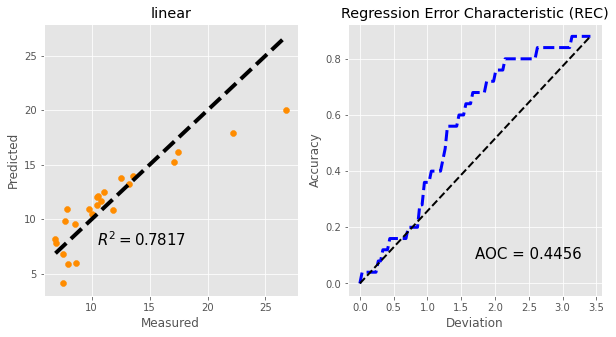

In [19]:
plot_rec_curve(demo_y_test, lin_y_hat, 'linear')

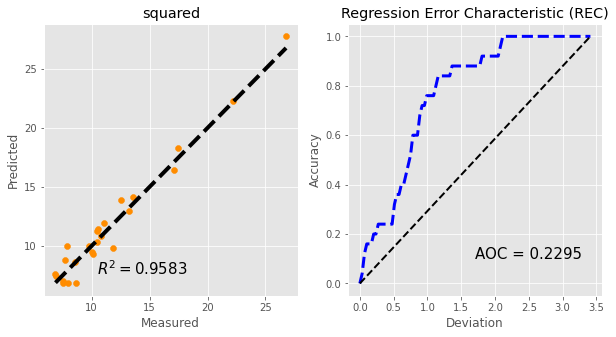

In [20]:
plot_rec_curve(demo_y_test, sqr_y_hat, 'squared')